# Imports

This is a notebook that you can use to generate predictions for the errors on g-g lensing. To use this notebook, you need to install colossus by Benedikt Diemer. Colossus was recently upgraded, we have not checked if this works with the latest version. You also need to specify certain parameters (e.g. bias of lens sample, properties of source sample).
The code only gives you the errors, not the amplitude of the Delta Sigma signal.

In [1]:
%matplotlib inline

#import camb
#pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
#from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from colossus.cosmology import cosmology
import numpy as np
from matplotlib import pylab as plt
import matplotlib.colors as colors
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const

import astropy.units as u
#rc('text', usetex=False)

In [2]:
cosmo   = FlatLambdaCDM(H0=70.0, Om0=0.3)
cosmoh1 = FlatLambdaCDM(H0=100.0,Om0=0.3)
#print(cosmo.H(0))
#print(cosmoh1.H(0))

# Setting up the parameters for lensing and lens sample

In [3]:
zlens=0.2      # mean lens (foreground) redshift
zlens_min=0.1  # lower z cut on lens sample 
zlens_max=0.3  # upper z cut on lens sample

zsource=0.8   # source (background) redshift

# These parameters are for a HSM-REGAUSS type shape measurements method
# Shape noise
sigma_e=.36

# shape noise with responsivity factor
sigma_gamma=sigma_e/1.7

# number of background galaxies in units of N/arcmin^2
ns_angular = 18

# b of lens sample
# Bias value of the DESI BGS sample 
blens=1.33636828

# Space density of the lens sample
# Get this from simulations
n_g=0.005
g_shot_noise=1./n_g

# Overlap area between DESI and HSC area in deg^2
area=1400

In [4]:
# Convert this to a number of background galaxies in units
# of N/(Mpc/h)^2 assuming the redshift of the lens sample
# At the lens redshifts in comoving h^-1
# Ang_distance = Transverse_size/theta_rad
arcmin2rad  =  np.pi/(180.0*60)   
transverse_size = (cosmoh1.angular_diameter_distance(zlens)*arcmin2rad)  #Mpc h^-1

# This value looks a lot larger than the one in Sukhdeep's original code?
n_s=ns_angular/np.square(transverse_size)  
n_s = n_s.value
print(n_s)

# dont understand why these numbers are so different, using the one in Sukhdeeps code is
# n_s=8
# NEED TO FIX HERE

# Bining in h^-1 Mpc
r_bins=np.logspace(np.log10(0.1),np.log10(70),25)
#print(r_bins)

# Area in comoving units
area_comoving=area*(np.pi/180)**2*cosmoh1.comoving_distance(z=zlens)**2

# line of sight window lenght between Zmax and Zmin
# redshift bins lens Mpc
L_W=cosmoh1.comoving_distance(z=zlens_max)-cosmoh1.comoving_distance(z=zlens_min)
vol=area_comoving*L_W
vol=vol.value

# this is the mean density at redshift zero
# (check that this should be the mean, and not the critical)
# RHO_MEAN(z)  = Omega_m(z) * Rho_c(z)
rho=cosmoh1.critical_density0.to(u.Msun/(u.pc*u.pc*u.Mpc))*cosmoh1.Om0
rho=rho.value

937.2263584416348


In [5]:
def sigma_crit(cosmo, zl, zs):
    constant_term = const.c*const.c/(4*np.pi*const.G)
    dist_term = cosmo.angular_diameter_distance(zs)/(cosmo.angular_diameter_distance_z1z2(zl,zs)*\
                                                     cosmo.angular_diameter_distance(zl))
    
    return (constant_term*dist_term*(1.0/(1+zl))**2).to(u.Msun/(u.pc*u.pc))

In [6]:
# critical surface mass density
# h inverse with 1+z factors comoving
my_val = sigma_crit(cosmoh1, zlens, zsource)
 
sigma_crit=my_val.value
shape_noise=sigma_crit**2*sigma_gamma**2/n_s#*cosmo.H_z(z=0.27)/cosmo.c
shape_noise 

562.0877441815603

# Get power spectrum

In [7]:
# Set up a new set of parameters for CAMB
# Here this is getting the non-linear matter power spectrum
kmax=30
kmin=.8e-3
k_smooth=1

# Note: CAMB automaticaly samples in log space
nk=5000
rmin=.6
rmax=110
non_linear=1

# We will test the differences between linear and non linear together with Sukhdeep

#pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
#pars.set_cosmology(H0=67.27, ombh2=0.022250, omch2=0.119800, mnu=0.06, omk=0, tau=0.06)
#pars.InitPower.set_params(ns=0.965, r=0,As =2.14e-09)
#pars.set_for_lmax(2500, lens_potential_accuracy=0)

# This is the redshift of the lens sample
#zb=[.27]#
#pars.set_matter_power(redshifts=zb,kmax=kmax);
#if non_linear==1:
#    pars.NonLinear = model.NonLinear_both
#else:
#    pars.NonLinear = model.NonLinear_none
#results = camb.get_results(pars)
#kh, z, pk =results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints =nk)

# Use linear or non linear
# Use linear but then test with Sukhdeep

# what is zb here?
# => lens Redshift

In [8]:
# define a vector of cosmological parameters
# Here I think one needs h not 1

my_cosmo = {'flat': True, 'H0': 73.0, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.74, 'ns': 0.951}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

0.005999839999999999
5000


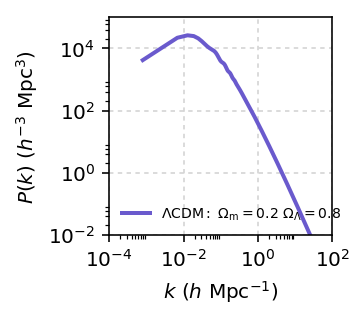

In [9]:
# input model spectrum for comparison
# lka = np.arange(-4.,3.,0.02)
#ka = 10.0**lka

# Do we want the sampling in log?
# Units of pk, make sure they are the same
# ask for the P(k) camb to see if it we get the same thing

# Sample in log space
# In parctice, the hankel transform does its own interpolation later down the line anyway and so 
# it shouldn't matter though
step=(kmax-kmin)/nk
print(step)

# Colosus assumed h/Mpc
kh = np.arange(kmin,kmax,step)
print(len(kh))

# In Colossus, growth function needs to be applied here
# The wavenumber k (in comoving h/Mpc)
g2 = (cosmo.growthFactor(zlens))**2
pk = cosmo.matterPowerSpectrum(kh, 'eh98')*g2
cosmo.interpolation = True

# plot input model P(k) 

plt.figure(figsize=(2,2))
plt.xscale('log'); plt.yscale('log')
plt.ylim(1.e-2, 1.e5); plt.xlim(1.e-4, 1.e2)
plt.plot(kh, pk, c='slateblue', linewidth=2., label=r'$\Lambda\mathrm{CDM}:\ \Omega_{\rm m}=%.1f\ \Omega_\Lambda=%.1f$'%(cosmo.Om0,cosmo.OL0))
plt.legend(frameon=False, loc='lower left', fontsize=7, scatterpoints=1)
plt.xlabel(r'$k\ (h\rm\ Mpc^{-1})$')
plt.ylabel(r'$P(k)\ (h^{-3}\ \rm Mpc^3)$')
plt.grid(linestyle='dotted', c='lightgray')
#plt.show()

In [10]:
#Setting up the Hankel Transform
#This deals with the interpolation over the Bessel Functions
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 1047
CPU times: user 14 s, sys: 199 ms, total: 14.2 s
Wall time: 14.2 s


In [11]:
# Note to ourselves: get the h factors correct

# CAMB version
# the CAMB version computes at multipe redshifts
# The [0] here is just taking the first redshifts
#pk_taper=HT.taper(k=kh,pk=pk[0],large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
#                     low_k_upper=kmin*2)

# This tapers to function at the edges to make it go to zero nicely
# To avoid runing when you take the fourier transform
pk_taper=HT.taper(k=kh,pk=pk,large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)


#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.
print(pk_taper)

[  2.57167663e-13   2.20420050e+04   2.64450688e+04 ...,   7.02522332e-06
   4.68094020e-06   2.33919992e-06]


# g-g Lensing covariance

We are using the real-space DS(r_p) covariance expression from Sukhdeep Singh's paper, Eq 10.
http://adsabs.harvard.edu/abs/2016arXiv161100752S

Here we are using the part withuot the curly brackets (as explained later in the text, if you subtract DS around randoms to get the optimal estimator, you get rid of the curly brackets term)

We are ignoring the connected $T_{g \gamma g \gamma}$ term, as it’s unlikely to be very important and is so much harder to calculate, and we are just keeping the $(P_{gg} + N_g) (P_{\gamma \gamma} + N_\gamma) + P_{g \gamma}^2$ stuff, so you have lens clustering and shot noise, cosmic shear and shape noise, and cosmic variance terms.

In [12]:
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[2],n_zeros=60000,kmin=kmin)

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 61000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 62000
nr: 1046
CPU times: user 30.7 s, sys: 541 ms, total: 31.2 s
Wall time: 31.4 s


In [13]:
# cnvergence power spectrum
# approximation
# just integrating 
# Dchi2 is the integral over the window function
Dchi2=900 #integral over product of window functions units is Mpc?
p_kappa_kappa=pk*(rho)**2*Dchi2

In [14]:
p_g=blens**2*pk
p_gk=blens*pk*rho

In [15]:
taper_kw=dict({'large_k_lower':10,'large_k_upper':kmax,'low_k_lower':kmin,'low_k_upper':kmin*1.2})

In [16]:
# Pgg x Pgammagamma
r,cov_ggkk=HT.projected_covariance(k_pk=kh,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa+shape_noise,j_nu=2,taper=True,**taper_kw)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/alexie/Work/DESI/LensingPredictions/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [17]:
# g gamma ^2
r,cov_gkgk=HT.projected_covariance(k_pk=kh,pk1=p_gk,pk2=p_gk,
                               kmax=100,rmin=.8,j_nu=2,rmax=110,n_zeros=3500)#return_Jrr=True,Jrr=Jrr
cov_gkgk*=Dchi2
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

/Users/alexie/Work/DESI/LensingPredictions/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [18]:
cov_final=(cov_ggkk_re+cov_gkgk_re)/vol
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)

#Errors
print(errors)

[ 0.          0.          0.          0.          0.          0.
  0.04999221  0.03721046  0.02782314  0.02397651  0.01746302  0.01466338
  0.01291154  0.01279295  0.01396142  0.01656504  0.02026576  0.02488914
  0.03015268  0.0357826   0.04132782  0.0461428   0.04943211  0.04984931]


/Users/alexie/Work/DESI/LensingPredictions/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [ ]:

plt.pcolor(r_re,r_re,corr,norm=colors.LogNorm())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(HT.rmin,HT.rmax)
plt.ylim(HT.rmin,HT.rmax)

In [ ]:
# This are the values at the middle of the bins
print(r_re)
print(errors)

# These are the errors on DS
plt.plot(r_re,errors,label='new')
#plot(error_qpm['rp'],error_qpm['rp']*error_qpm['DS_err_gR'])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0.1,100)